In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import h5py
from IPython.display import display
import numpy as np
from os.path import join as pj
from os import getcwd as cwd
import pandas as pd
import random
import sys
import torch
from tqdm import tqdm
import visdom

# Logger
from IO.logger import Logger
# Data Augument
from dataset.classification.loader import create_validation_split, load_validation_data, create_train_data, create_train_data_DCL
# Data Sampling
from dataset.classification.sampler import get_randomsampled_idx, get_randomoversampled_idx
# RCM
from dataset.classification.region_confusion_mechanism import region_confusion_mechanism
# Model
from model.resnet.utils import define_weight
from model.resnet.predict import test_classification
from model.optimizer import AdamW
# Evaluation
from evaluation.classification.evaluate import accuracy, confusion_matrix
# Statistics
from evaluation.classification.statistics import compute_each_size_df, compute_all_size_df
# Visualize
from evaluation.classification.visualize import create_confusion_matrix, plot_df_distrib_size

# Train Config

In [3]:
class args:
    # experiment_name
    experiment_name = "resnet50_b20_r45_lr1e-5_crossvalid_aaaaa"
    # data split
    train_ratio = 0.8 # unused parameters
    test_ratio = 0.2
    # paths
    all_data_path = pj(cwd(), "data/all_classification_data/classify_insect_std_aquatic")
    model_root = pj(cwd(), "output_model/classification/ResNet101", experiment_name)
    figure_root = pj(cwd(), "figure/classification/ResNet101", experiment_name)
    # class names to visualize
    #labels =  ['Aquatic_insects', 'Other_insects']
    labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
               'Lepidoptera', 'Plecoptera', 'Trichoptera']
    #labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
    #           'Lepidoptera', 'Plecoptera', 'Trichoptera', 
    #           'Coleoptera', 'Hemiptera', 'medium insect', 'small insect']
    # train config
    model_name = "ResNet50" # choice ["ResNet18", "ResNet34", "ResNet50", "ResNet101"]
    use_DCL = False
    division_number = 7
    neighborhood_range = 1
    cls_weight = 1
    dest_weight = 10
    coord_weight = 0.1
    bs = 20
    lr = 1e-5
    nepoch = 40
    rotate = 45
    pretrain = True
    freeze = False
    sampling = None # choice [None, "RandomSample", "RandomOverSample"]
    augment = None # choice [None, "RandomSizeCrop"]
    optimizer = "AdamW" # choice ["Adam, AdamW"]
    correction_term = True
    # test config
    save_fig = True
    save_df = True
    # visdom
    visdom = True
    port = 8097

# Load Model

In [4]:
# Model
if args.model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
elif args.model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
elif args.model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
elif args.model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
else:
    print("error! write correct model name!")

# Train

In [5]:
def train(model, xtr, ytr, bs=20, lr=1e-5, nepoch=40, visdom=False):
    # calculate counts and count_sum
    _, counts = np.unique(ytr, return_counts=True)
    counts_sum = counts.sum()
    
    # define weight and create loss function
    ce = torch.nn.CrossEntropyLoss(define_weight(counts))
    
    # define optimizer
    if args.optimizer == "Adam":
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif args.optimizer == "AdamW":
        opt = AdamW(model.parameters(), lr=lr)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    t = tqdm(range(nepoch),leave=False)
    # training
    for epoch in t:
        total_loss = 0
        index = random.sample(range(counts_sum),counts_sum)
        t.set_description("epoch=%s" % (epoch))
        for idx in range(0,counts_sum-bs,bs):
            idx = index[idx:idx+bs]
            x = xtr[idx].cuda()
            y = ytr[idx].cuda()
            opt.zero_grad()
            out = model(x)
            loss = ce(out, y)
            total_loss += loss.item()
            loss.backward()
            opt.step()
        
        model.training = False
        if args.correction_term == True:
            te_acc, correction_term = accuracy(model, xte, yte, bs, return_correction_term=True)
            ce = torch.nn.CrossEntropyLoss(define_weight(counts) * correction_term)
            print(correction_term)
        else:
            te_acc = accuracy(model, xte, yte, bs, return_correction_term=False)
        model.training = True
        if visdom:
            visualize(vis, epoch+1, total_loss, win_train_loss)
            visualize(vis, epoch+1, te_acc, win_test_acc)
        sys.stdout.write("\rtotal_loss=%f, te_acc=%f" % (total_loss,te_acc))
        sys.stdout.flush()
        

def train_DCL(model, xtr, ytr, target_dest_or_not, target_coordinate, bs=20, lr=1e-5, nepoch=40, visdom=False, cls_weight=1, dest_weight=10, coord_weight=0.1):
    # calculate counts and count_sum
    _, counts = np.unique(ytr, return_counts=True)
    counts_sum = counts.sum()
    
    # define weight and create loss function
    cls_ce = torch.nn.CrossEntropyLoss(define_weight(counts))
    dest_ce = torch.nn.CrossEntropyLoss()
    coord_l1 = torch.nn.L1Loss()
    
    # define optimizer
    if args.optimizer == "Adam":
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif args.optimizer == "AdamW":
        opt = AdamW(model.parameters(), lr=lr)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    t = tqdm(range(nepoch),leave=False)
    # training
    for epoch in t:
        sum_cls_loss = 0
        sum_dest_loss = 0
        sum_coord_loss = 0
        total_loss = 0
        index = random.sample(range(counts_sum),counts_sum)
        t.set_description("epoch=%s" % (epoch))
        for idx in range(0,counts_sum-bs,bs):
            idx = index[idx:idx+bs]
            x = xtr[idx].cuda()
            y = ytr[idx].cuda()
            sample_dest_or_not = target_dest_or_not[idx].cuda()
            sample_coordinate = target_coordinate[idx].cuda()
            opt.zero_grad()
            out, predict_loc, dest_or_not = model(x)
            cls_loss = cls_ce(out, y) * cls_weight
            dest_loss = dest_ce(dest_or_not, sample_dest_or_not) * dest_weight
            coord_loss = coord_l1(predict_loc, sample_coordinate) * coord_weight
            loss = cls_loss + dest_loss + coord_loss
            sum_cls_loss += cls_loss.item()
            sum_dest_loss += dest_loss.item()
            sum_coord_loss += coord_loss.item()
            total_loss += loss.item()
            loss.backward()
            opt.step()
        
        model.training = False
        te_acc = accuracy(model, xte, yte, bs)
        model.training = True
        if visdom:
            visualize(vis, epoch+1, sum_cls_loss, win_cls_loss)
            visualize(vis, epoch+1, sum_dest_loss, win_dest_loss)
            visualize(vis, epoch+1, sum_coord_loss, win_coord_loss)
            visualize(vis, epoch+1, total_loss, win_train_loss)
            visualize(vis, epoch+1, te_acc, win_test_acc)
        sys.stdout.write("\rcls_loss=%f, dest_loss=%f, coord_loss=%f, train_loss=%f, te_acc=%f" % (sum_cls_loss, sum_dest_loss, sum_coord_loss, total_loss, te_acc))
        sys.stdout.flush()

# Set Visdom

In [6]:
if args.visdom:
    # Create visdom
    vis = visdom.Visdom(port=args.port)
    
    """train_loss"""
    win_train_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    """test_accuracy"""
    win_test_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='test_accuracy',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    
    if args.use_DCL is True:
        """train_loss"""
        win_cls_loss = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='classification_loss',
                xlabel='epoch',
                ylabel='loss',
                width=800,
                height=400
            )
        )
        win_dest_loss = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='adversarial_loss',
                xlabel='epoch',
                ylabel='loss',
                width=800,
                height=400
            )
        )
        win_coord_loss = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='coordinate_loss',
                xlabel='epoch',
                ylabel='loss',
                width=800,
                height=400
            )
        )

Setting up a new session...


In [7]:
def visualize(vis, phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )

### Save args

In [8]:
args_logger = Logger(args)
args_logger.save()

# Cross Validation

In [9]:
model_save_path = pj(args.model_root, "final.pth")
if os.path.exists(args.model_root) is False:
    os.makedirs(args.model_root)
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [10]:
valid_num = int(1.0/args.test_ratio)
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)

In [11]:
valid_num = int(1.0/args.test_ratio)
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)
result = []
for valid_count in range(valid_num):
    if args.sampling == "RandomSample":
        print("sampling = RandomSample")
        new_train_idx = get_randomsampled_idx(Y, train_idxs[valid_count])
        xtr, ytr, xte, yte = load_validation_data(X, Y, new_train_idx, test_idxs[valid_count])
    elif args.sampling == "RandomOverSample":
        print("sampling == RandomOverSample")
        new_train_idx = get_randomoversampled_idx(Y, train_idxs[valid_count])
        xtr, ytr, xte, yte = load_validation_data(X, Y, new_train_idx, test_idxs[valid_count])
    else:
        print("sampling = None")
        xtr, ytr, xte, yte = load_validation_data(X, Y, train_idxs[valid_count], test_idxs[valid_count])
    
    if args.use_DCL is True:
        new_xtr, new_coordinate = region_confusion_mechanism(xtr, division_number=args.division_number, neighborhood_range=args.neighborhood_range)
        xtr = np.concatenate([xtr, new_xtr])
        ytr = np.concatenate([ytr, ytr])
        target_dest_or_not = np.concatenate([np.zeros(ytr.shape), np.ones(ytr.shape)])
        target_coordinate = np.concatenate([new_coordinate, np.asarray([np.arange(args.division_number**2)] * new_coordinate.shape[0])])
        xtr, ytr, target_dest_or_not, target_coordinate = create_train_data_DCL(xtr, ytr, target_dest_or_not, target_coordinate, args.rotate, args.augment)
    else:
        xtr, ytr = create_train_data(xtr, ytr, args.rotate, args.augment)
    
    if args.model_name=="ResNet18":
        model = ResNet18(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    elif args.model_name=="ResNet34":
        model = ResNet34(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    elif args.model_name=="ResNet50":
        model = ResNet50(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    elif args.model_name=="ResNet101":
        model = ResNet101(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    else:
        print("error! write correct model name!")
    
    if args.use_DCL is True:
        train_DCL(model, xtr, ytr, target_dest_or_not, target_coordinate, bs=args.bs, lr=args.lr, nepoch=args.nepoch, visdom=args.visdom, cls_weight=args.cls_weight, dest_weight=args.dest_weight, coord_weight=args.coord_weight)
    else:
        train(model, xtr, ytr, bs=args.bs, lr=args.lr, nepoch=args.nepoch, visdom=args.visdom)
            
    torch.save(model.state_dict(), model_save_path)
    
    model.training = False
    matrix = confusion_matrix(model, xte, yte, args.labels, bs=args.bs)
    model.training = True
    df = pd.DataFrame(matrix)
    display(df)
    if valid_count == 0:
        validation_matrix = matrix
        x_all = xte.cpu().numpy()
        y_all = yte.cpu().numpy()
    else:
        validation_matrix += matrix
        x_all = np.concatenate([x_all, xte.cpu().numpy()])
        y_all = np.concatenate([y_all, yte.cpu().numpy()])
    
    result.extend(test_classification(model, xte))

sampling = None


  0%|          | 2/1059 [00:00<01:44, 10.11it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

tensor([1.1507, 1.2500, 2.0000, 1.1489, 1.2273, 1.1364], device='cuda:0')
total_loss=441.069077, te_acc=0.807547

epoch=1:   2%|▎         | 1/40 [00:43<28:06, 43.25s/it]

tensor([1.1053, 1.4286, 1.2903, 1.1489, 1.2857, 1.1364], device='cuda:0')
total_loss=203.156467, te_acc=0.852830

epoch=2:   5%|▌         | 2/40 [01:27<27:30, 43.45s/it]

tensor([1.0769, 1.4286, 1.6000, 1.1250, 1.2857, 1.1364], device='cuda:0')
total_loss=114.814287, te_acc=0.841509

epoch=3:   8%|▊         | 3/40 [02:12<27:09, 44.03s/it]

tensor([1.1200, 1.0000, 1.4286, 1.1489, 1.1739, 1.0870], device='cuda:0')
total_loss=77.128796, te_acc=0.864151

epoch=4:  10%|█         | 4/40 [02:58<26:44, 44.56s/it]

tensor([1.1053, 1.2500, 1.4286, 1.0588, 1.2857, 1.1364], device='cuda:0')
total_loss=54.588873, te_acc=0.860377

epoch=5:  12%|█▎        | 5/40 [03:43<26:06, 44.76s/it]

tensor([1.1053, 1.2500, 1.2121, 1.0588, 1.2273, 1.1628], device='cuda:0')
total_loss=42.728462, te_acc=0.879245

epoch=6:  15%|█▌        | 6/40 [04:29<25:30, 45.01s/it]

tensor([1.1053, 1.2500, 1.3793, 1.1250, 1.3500, 1.1111], device='cuda:0')
total_loss=30.486556, te_acc=0.852830

epoch=7:  18%|█▊        | 7/40 [05:14<24:47, 45.07s/it]

tensor([1.1200, 1.4286, 1.1429, 1.1250, 1.2857, 1.1905], device='cuda:0')
total_loss=26.934296, te_acc=0.860377

epoch=8:  20%|██        | 8/40 [05:59<24:05, 45.18s/it]

tensor([1.0909, 1.4286, 1.2903, 1.1250, 1.2857, 1.0870], device='cuda:0')
total_loss=20.777232, te_acc=0.867925

epoch=9:  22%|██▎       | 9/40 [06:44<23:19, 45.16s/it]

tensor([1.0769, 1.2500, 1.4286, 1.0800, 1.2273, 1.1364], device='cuda:0')
total_loss=18.917115, te_acc=0.867925

epoch=10:  25%|██▌       | 10/40 [07:30<22:35, 45.20s/it]

tensor([1.0909, 1.2500, 1.5385, 1.0800, 1.1250, 1.1111], device='cuda:0')
total_loss=17.988357, te_acc=0.867925

epoch=11:  28%|██▊       | 11/40 [08:15<21:53, 45.30s/it]

tensor([1.1200, 1.2500, 1.3793, 1.1020, 1.2273, 1.0870], device='cuda:0')
total_loss=15.631863, te_acc=0.864151

epoch=12:  30%|███       | 12/40 [09:01<21:09, 45.35s/it]

tensor([1.0909, 1.2500, 1.1429, 1.1250, 1.0800, 1.1111], device='cuda:0')
total_loss=12.337788, te_acc=0.898113

epoch=13:  32%|███▎      | 13/40 [09:46<20:23, 45.33s/it]

tensor([1.1053, 1.2500, 1.5385, 1.0800, 1.2273, 1.0870], device='cuda:0')
total_loss=12.982444, te_acc=0.860377

epoch=14:  35%|███▌      | 14/40 [10:31<19:39, 45.38s/it]

tensor([1.1053, 1.4286, 1.3793, 1.1250, 1.2857, 1.0870], device='cuda:0')
total_loss=8.791158, te_acc=0.856604

epoch=15:  38%|███▊      | 15/40 [11:17<18:56, 45.46s/it]

tensor([1.0769, 1.4286, 1.3333, 1.1020, 1.1739, 1.0870], device='cuda:0')
total_loss=6.562983, te_acc=0.879245

epoch=16:  40%|████      | 16/40 [12:02<18:08, 45.37s/it]

tensor([1.0909, 1.2500, 1.2903, 1.1020, 1.2273, 1.0870], device='cuda:0')
total_loss=9.725097, te_acc=0.879245

epoch=17:  42%|████▎     | 17/40 [12:48<17:26, 45.49s/it]

tensor([1.1053, 1.4286, 1.3333, 1.0800, 1.2273, 1.0870], device='cuda:0')
total_loss=8.805855, te_acc=0.871698

epoch=18:  45%|████▌     | 18/40 [13:33<16:39, 45.43s/it]

tensor([1.1200, 1.2500, 1.2903, 1.1020, 1.2857, 1.0638], device='cuda:0')
total_loss=8.943837, te_acc=0.871698

epoch=19:  48%|████▊     | 19/40 [14:19<15:54, 45.46s/it]

tensor([1.1351, 1.1111, 1.3793, 1.0588, 1.3500, 1.0870], device='cuda:0')
total_loss=8.638564, te_acc=0.864151

epoch=20:  50%|█████     | 20/40 [15:04<15:08, 45.43s/it]

tensor([1.1351, 1.4286, 1.2500, 1.1250, 1.4211, 1.1111], device='cuda:0')
total_loss=5.104040, te_acc=0.849057

epoch=21:  52%|█████▎    | 21/40 [15:50<14:22, 45.38s/it]

tensor([1.0909, 1.1111, 1.3793, 1.1250, 1.2273, 1.1111], device='cuda:0')
total_loss=9.579953, te_acc=0.867925

epoch=22:  55%|█████▌    | 22/40 [16:35<13:36, 45.38s/it]

tensor([1.0500, 1.2500, 1.3793, 1.1020, 1.3500, 1.0870], device='cuda:0')
total_loss=3.563946, te_acc=0.875472

epoch=23:  57%|█████▊    | 23/40 [17:20<12:51, 45.35s/it]

tensor([1.1053, 1.2500, 1.3333, 1.1020, 1.2857, 1.0870], device='cuda:0')
total_loss=5.671564, te_acc=0.867925

epoch=24:  60%|██████    | 24/40 [18:06<12:06, 45.43s/it]

tensor([1.0909, 1.2500, 1.2121, 1.1739, 1.1739, 1.1111], device='cuda:0')
total_loss=8.317059, te_acc=0.875472

epoch=25:  62%|██████▎   | 25/40 [18:51<11:21, 45.43s/it]

tensor([1.0769, 1.1111, 1.3333, 1.1250, 1.1739, 1.1111], device='cuda:0')
total_loss=4.367133, te_acc=0.879245

epoch=26:  65%|██████▌   | 26/40 [19:37<10:36, 45.44s/it]

tensor([1.0909, 1.2500, 1.3793, 1.1020, 1.2857, 1.0870], device='cuda:0')
total_loss=7.544051, te_acc=0.867925

epoch=27:  68%|██████▊   | 27/40 [20:22<09:51, 45.49s/it]

tensor([1.1200, 1.2500, 1.4815, 1.0189, 1.0385, 1.1111], device='cuda:0')
total_loss=6.492603, te_acc=0.883019

epoch=28:  70%|███████   | 28/40 [21:08<09:05, 45.43s/it]

tensor([1.1200, 1.2500, 1.2500, 1.0800, 1.1739, 1.0870], device='cuda:0')
total_loss=6.282545, te_acc=0.883019

epoch=29:  72%|███████▎  | 29/40 [21:53<08:19, 45.44s/it]

tensor([1.1200, 1.1111, 1.2903, 1.0800, 1.2857, 1.1111], device='cuda:0')
total_loss=2.956299, te_acc=0.871698

epoch=30:  75%|███████▌  | 30/40 [22:38<07:33, 45.39s/it]

tensor([1.1053, 1.2500, 1.3333, 1.0588, 1.1250, 1.1111], device='cuda:0')
total_loss=2.725633, te_acc=0.883019

epoch=31:  78%|███████▊  | 31/40 [23:24<06:48, 45.41s/it]

tensor([1.0769, 1.4286, 1.3793, 1.0189, 1.1739, 1.0870], device='cuda:0')
total_loss=5.429179, te_acc=0.890566

epoch=32:  80%|████████  | 32/40 [24:09<06:03, 45.40s/it]

tensor([1.0909, 1.1111, 1.4286, 1.1020, 1.1739, 1.0870], device='cuda:0')
total_loss=2.902988, te_acc=0.875472

epoch=33:  82%|████████▎ | 33/40 [24:54<05:17, 45.34s/it]

tensor([1.0909, 1.4286, 1.3333, 1.1250, 1.1250, 1.1364], device='cuda:0')
total_loss=4.874183, te_acc=0.867925

epoch=34:  85%|████████▌ | 34/40 [25:40<04:32, 45.40s/it]

tensor([1.1351, 1.2500, 1.1765, 1.0385, 1.3500, 1.1111], device='cuda:0')
total_loss=7.911065, te_acc=0.879245

epoch=35:  88%|████████▊ | 35/40 [26:25<03:46, 45.39s/it]

tensor([1.1053, 1.1111, 1.2121, 1.0588, 1.2273, 1.1364], device='cuda:0')
total_loss=2.972736, te_acc=0.886792

epoch=36:  90%|█████████ | 36/40 [27:11<03:01, 45.41s/it]

tensor([1.0909, 1.4286, 1.2903, 1.1020, 1.2857, 1.0870], device='cuda:0')
total_loss=5.346723, te_acc=0.871698

epoch=37:  92%|█████████▎| 37/40 [27:56<02:16, 45.46s/it]

tensor([1.1507, 1.1111, 1.1111, 1.0588, 1.1739, 1.0870], device='cuda:0')
total_loss=3.677037, te_acc=0.898113

epoch=38:  95%|█████████▌| 38/40 [28:42<01:30, 45.41s/it]

tensor([1.1053, 1.2500, 1.3333, 1.0385, 1.2273, 1.1111], device='cuda:0')
total_loss=2.905244, te_acc=0.879245

epoch=39:  98%|█████████▊| 39/40 [29:27<00:45, 45.47s/it]

tensor([1.1053, 1.2500, 1.1765, 1.0588, 1.2273, 1.1111], device='cuda:0')
total_loss=1.952118, te_acc=0.890566

,0,1,2,3,4,5
0,76.0,2.0,3.0,2.0,0.0,1.0
1,0.0,8.0,0.0,2.0,0.0,0.0
2,2.0,2.0,34.0,1.0,0.0,1.0
3,0.0,1.0,1.0,51.0,0.0,1.0
4,1.0,0.0,4.0,0.0,22.0,0.0
5,0.0,0.0,2.0,3.0,0.0,45.0


sampling = None


  0%|          | 2/1059 [00:00<01:43, 10.19it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

tensor([1.1831, 1.0000, 1.4815, 1.2857, 1.4211, 1.2821], device='cuda:0')
total_loss=425.142772, te_acc=0.784906

epoch=1:   2%|▎         | 1/40 [00:43<28:19, 43.59s/it]

tensor([1.1831, 1.0000, 1.3793, 1.2000, 1.3500, 1.1364], device='cuda:0')
total_loss=207.245313, te_acc=0.826415

epoch=2:   5%|▌         | 2/40 [01:28<27:49, 43.93s/it]

tensor([1.2000, 1.0000, 1.3333, 1.1739, 1.3500, 1.0638], device='cuda:0')
total_loss=118.518575, te_acc=0.841509

epoch=3:   8%|▊         | 3/40 [02:13<27:24, 44.44s/it]

tensor([1.1507, 1.0000, 1.2500, 1.2273, 1.1739, 1.1111], device='cuda:0')
total_loss=79.375417, te_acc=0.856604

epoch=4:  10%|█         | 4/40 [02:59<26:47, 44.66s/it]

tensor([1.1351, 1.0000, 1.3793, 1.1250, 1.1739, 1.1364], device='cuda:0')
total_loss=53.301325, te_acc=0.860377

epoch=5:  12%|█▎        | 5/40 [03:44<26:11, 44.90s/it]

tensor([1.1200, 1.0000, 1.2121, 1.1489, 1.2857, 1.1364], device='cuda:0')
total_loss=43.268765, te_acc=0.867925

epoch=6:  15%|█▌        | 6/40 [04:29<25:30, 45.03s/it]

tensor([1.1507, 1.0000, 1.1765, 1.2000, 1.2857, 1.0870], device='cuda:0')
total_loss=26.341328, te_acc=0.864151

epoch=7:  18%|█▊        | 7/40 [05:15<24:51, 45.19s/it]

tensor([1.1507, 1.0000, 1.2500, 1.2558, 1.1250, 1.0870], device='cuda:0')
total_loss=22.699942, te_acc=0.860377

epoch=8:  20%|██        | 8/40 [06:00<24:08, 45.25s/it]

tensor([1.1053, 1.0000, 1.3793, 1.2273, 1.1739, 1.1628], device='cuda:0')
total_loss=25.092934, te_acc=0.849057

epoch=9:  22%|██▎       | 9/40 [06:46<23:24, 45.32s/it]

tensor([1.1507, 1.0000, 1.4286, 1.1020, 1.1739, 1.0870], device='cuda:0')
total_loss=19.165857, te_acc=0.864151

epoch=10:  25%|██▌       | 10/40 [07:31<22:38, 45.28s/it]

tensor([1.1053, 1.0000, 1.2500, 1.2558, 1.5882, 1.0638], device='cuda:0')
total_loss=14.006507, te_acc=0.849057

epoch=11:  28%|██▊       | 11/40 [08:17<21:56, 45.39s/it]

tensor([1.0909, 1.0000, 1.3333, 1.1020, 1.2857, 1.1364], device='cuda:0')
total_loss=12.130217, te_acc=0.871698

epoch=12:  30%|███       | 12/40 [09:02<21:10, 45.39s/it]

tensor([1.1351, 1.0000, 1.3793, 1.1020, 1.2273, 1.1111], device='cuda:0')
total_loss=14.565366, te_acc=0.864151

epoch=13:  32%|███▎      | 13/40 [09:48<20:27, 45.46s/it]

tensor([1.1831, 1.0000, 1.2500, 1.1250, 1.1739, 1.1364], device='cuda:0')
total_loss=13.508265, te_acc=0.860377

epoch=14:  35%|███▌      | 14/40 [10:33<19:43, 45.50s/it]

tensor([1.1667, 1.0000, 1.2903, 1.1020, 1.2273, 1.1111], device='cuda:0')
total_loss=6.290663, te_acc=0.864151

epoch=15:  38%|███▊      | 15/40 [11:19<18:57, 45.51s/it]

tensor([1.0633, 1.0000, 1.4815, 1.1739, 1.0385, 1.1628], device='cuda:0')
total_loss=7.954885, te_acc=0.871698

epoch=16:  40%|████      | 16/40 [12:04<18:11, 45.47s/it]

tensor([1.1351, 1.0000, 1.2903, 1.1739, 1.3500, 1.0638], device='cuda:0')
total_loss=10.977825, te_acc=0.860377

epoch=17:  42%|████▎     | 17/40 [12:50<17:26, 45.52s/it]

tensor([1.1053, 1.0000, 1.2121, 1.2273, 1.2273, 1.0870], device='cuda:0')
total_loss=11.451220, te_acc=0.871698

epoch=18:  45%|████▌     | 18/40 [13:35<16:40, 45.49s/it]

tensor([1.0909, 1.0000, 1.2500, 1.1020, 1.2273, 1.0870], device='cuda:0')
total_loss=5.741889, te_acc=0.890566

epoch=19:  48%|████▊     | 19/40 [14:21<15:55, 45.48s/it]

tensor([1.1200, 1.0000, 1.2121, 1.1739, 1.5000, 1.0870], device='cuda:0')
total_loss=6.818318, te_acc=0.860377

epoch=20:  50%|█████     | 20/40 [15:06<15:09, 45.46s/it]

tensor([1.1507, 1.1111, 1.2121, 1.2000, 1.2273, 1.0638], device='cuda:0')
total_loss=10.474475, te_acc=0.864151

epoch=21:  52%|█████▎    | 21/40 [15:52<14:24, 45.52s/it]

tensor([1.1200, 1.1111, 1.1429, 1.1250, 1.1250, 1.1111], device='cuda:0')
total_loss=6.413413, te_acc=0.890566

epoch=22:  55%|█████▌    | 22/40 [16:37<13:39, 45.53s/it]

tensor([1.0769, 1.0000, 1.2500, 1.1250, 1.1250, 1.1628], device='cuda:0')
total_loss=3.493266, te_acc=0.886792

epoch=23:  57%|█████▊    | 23/40 [17:23<12:53, 45.47s/it]

tensor([1.1200, 1.0000, 1.1429, 1.1250, 1.1250, 1.1111], device='cuda:0')
total_loss=3.002339, te_acc=0.894340

epoch=24:  60%|██████    | 24/40 [18:08<12:06, 45.40s/it]

tensor([1.0769, 1.0000, 1.2121, 1.1739, 1.3500, 1.1111], device='cuda:0')
total_loss=7.507006, te_acc=0.875472

epoch=25:  62%|██████▎   | 25/40 [18:54<11:22, 45.50s/it]

tensor([1.0909, 1.1111, 1.2903, 1.2000, 1.1739, 1.1111], device='cuda:0')
total_loss=8.657924, te_acc=0.867925

epoch=26:  65%|██████▌   | 26/40 [19:39<10:36, 45.43s/it]

tensor([1.1053, 1.0000, 1.1429, 1.1489, 1.2273, 1.1111], device='cuda:0')
total_loss=7.260321, te_acc=0.886792

epoch=27:  68%|██████▊   | 27/40 [20:24<09:50, 45.46s/it]

tensor([1.0909, 1.0000, 1.2121, 1.1739, 1.2273, 1.1111], device='cuda:0')
total_loss=4.109846, te_acc=0.879245

epoch=28:  70%|███████   | 28/40 [21:10<09:06, 45.52s/it]

tensor([1.1053, 1.0000, 1.2121, 1.1739, 1.2857, 1.0870], device='cuda:0')
total_loss=5.082537, te_acc=0.875472

epoch=29:  72%|███████▎  | 29/40 [21:56<08:20, 45.50s/it]

tensor([1.1053, 1.0000, 1.2500, 1.1250, 1.2273, 1.0870], device='cuda:0')
total_loss=4.508911, te_acc=0.883019

epoch=30:  75%|███████▌  | 30/40 [22:42<07:36, 45.63s/it]

tensor([1.1351, 1.0000, 1.2121, 1.2000, 1.1739, 1.1111], device='cuda:0')
total_loss=6.527102, te_acc=0.867925

epoch=31:  78%|███████▊  | 31/40 [23:27<06:50, 45.57s/it]

tensor([1.1200, 1.0000, 1.1429, 1.2000, 1.1739, 1.0870], device='cuda:0')
total_loss=6.582055, te_acc=0.883019

epoch=32:  80%|████████  | 32/40 [24:12<06:04, 45.57s/it]

tensor([1.0909, 1.0000, 1.2121, 1.1739, 1.2273, 1.0870], device='cuda:0')
total_loss=1.763713, te_acc=0.883019

epoch=33:  82%|████████▎ | 33/40 [24:58<05:19, 45.60s/it]

tensor([1.1200, 1.0000, 1.2500, 1.1250, 1.1739, 1.1111], device='cuda:0')
total_loss=4.756004, te_acc=0.879245

epoch=34:  85%|████████▌ | 34/40 [25:44<04:33, 45.57s/it]

tensor([1.0909, 1.0000, 1.1429, 1.1739, 1.2273, 1.0870], device='cuda:0')
total_loss=4.216922, te_acc=0.890566

epoch=35:  88%|████████▊ | 35/40 [26:29<03:47, 45.51s/it]

tensor([1.1053, 1.0000, 1.2500, 1.2558, 1.2273, 1.0870], device='cuda:0')
total_loss=3.149972, te_acc=0.864151

epoch=36:  90%|█████████ | 36/40 [27:15<03:02, 45.53s/it]

tensor([1.0909, 1.0000, 1.2121, 1.2000, 1.2857, 1.0870], device='cuda:0')
total_loss=8.242486, te_acc=0.875472

epoch=37:  92%|█████████▎| 37/40 [28:00<02:16, 45.57s/it]

tensor([1.1053, 1.0000, 1.1429, 1.1250, 1.2273, 1.0870], device='cuda:0')
total_loss=4.132611, te_acc=0.894340

epoch=38:  95%|█████████▌| 38/40 [28:46<01:30, 45.49s/it]

tensor([1.0500, 1.0000, 1.3793, 1.1020, 1.2273, 1.0870], device='cuda:0')
total_loss=4.853378, te_acc=0.890566

epoch=39:  98%|█████████▊| 39/40 [29:31<00:45, 45.58s/it]

tensor([1.0769, 1.0000, 1.1765, 1.1739, 1.1250, 1.1905], device='cuda:0')
total_loss=4.464117, te_acc=0.883019

,0,1,2,3,4,5
0,78.0,0.0,5.0,0.0,1.0,0.0
1,0.0,10.0,0.0,0.0,0.0,0.0
2,2.0,3.0,34.0,1.0,0.0,0.0
3,4.0,0.0,1.0,46.0,1.0,2.0
4,0.0,0.0,0.0,0.0,24.0,3.0
5,1.0,0.0,2.0,2.0,3.0,42.0


sampling = None


  0%|          | 2/1059 [00:00<01:43, 10.19it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

tensor([1.2537, 1.0000, 1.9048, 1.2857, 1.3500, 1.3889], device='cuda:0')
total_loss=433.577348, te_acc=0.739623

epoch=1:   2%|▎         | 1/40 [00:43<28:21, 43.64s/it]

tensor([1.1831, 1.1111, 1.6667, 1.0800, 1.6875, 1.2500], device='cuda:0')
total_loss=200.170427, te_acc=0.792453

epoch=2:   5%|▌         | 2/40 [01:28<27:54, 44.07s/it]

tensor([1.1200, 1.2500, 1.7391, 1.0385, 1.5000, 1.2500], device='cuda:0')
total_loss=116.767354, te_acc=0.815094

epoch=3:   8%|▊         | 3/40 [02:14<27:27, 44.54s/it]

tensor([1.1053, 1.0000, 1.8182, 1.0588, 1.3500, 1.1628], device='cuda:0')
total_loss=77.276406, te_acc=0.837736

epoch=4:  10%|█         | 4/40 [02:59<26:52, 44.80s/it]

tensor([1.1053, 1.0000, 1.3333, 1.0588, 1.5882, 1.0638], device='cuda:0')
total_loss=55.096500, te_acc=0.871698

epoch=5:  12%|█▎        | 5/40 [03:45<26:17, 45.07s/it]

tensor([1.0909, 1.0000, 1.6667, 1.0385, 1.2857, 1.1905], device='cuda:0')
total_loss=38.041046, te_acc=0.852830

epoch=6:  15%|█▌        | 6/40 [04:30<25:36, 45.20s/it]

tensor([1.1053, 1.0000, 1.5385, 1.0800, 1.2273, 1.1111], device='cuda:0')
total_loss=35.765186, te_acc=0.864151

epoch=7:  18%|█▊        | 7/40 [05:16<24:58, 45.41s/it]

tensor([1.0769, 1.0000, 1.2500, 1.1250, 1.2857, 1.1628], device='cuda:0')
total_loss=21.789369, te_acc=0.875472

epoch=8:  20%|██        | 8/40 [06:02<24:15, 45.48s/it]

tensor([1.1507, 1.0000, 1.4286, 1.0588, 1.1739, 1.1628], device='cuda:0')
total_loss=16.715792, te_acc=0.860377

epoch=9:  22%|██▎       | 9/40 [06:47<23:29, 45.47s/it]

tensor([1.0633, 1.0000, 1.7391, 1.0588, 1.3500, 1.1111], device='cuda:0')
total_loss=17.314849, te_acc=0.860377

epoch=10:  25%|██▌       | 10/40 [07:33<22:47, 45.59s/it]

tensor([1.1507, 1.0000, 1.4286, 1.0588, 1.1739, 1.0870], device='cuda:0')
total_loss=14.155037, te_acc=0.871698

epoch=11:  28%|██▊       | 11/40 [08:19<22:02, 45.60s/it]

tensor([1.1200, 1.0000, 1.5385, 1.1250, 1.1739, 1.2500], device='cuda:0')
total_loss=16.911767, te_acc=0.837736

epoch=12:  30%|███       | 12/40 [09:05<21:17, 45.63s/it]

tensor([1.0909, 1.0000, 1.2903, 1.1250, 1.2273, 1.2500], device='cuda:0')
total_loss=13.233456, te_acc=0.860377

epoch=13:  32%|███▎      | 13/40 [09:51<20:33, 45.70s/it]

tensor([1.0909, 1.0000, 1.3333, 1.0800, 1.2273, 1.1905], device='cuda:0')
total_loss=11.113258, te_acc=0.871698

epoch=14:  35%|███▌      | 14/40 [10:36<19:46, 45.64s/it]

tensor([1.1351, 1.0000, 1.3793, 1.1020, 1.2857, 1.1905], device='cuda:0')
total_loss=5.017846, te_acc=0.849057

epoch=15:  38%|███▊      | 15/40 [11:21<18:58, 45.55s/it]

tensor([1.0769, 1.0000, 1.3333, 1.0588, 1.2857, 1.2195], device='cuda:0')
total_loss=13.020075, te_acc=0.871698

epoch=16:  40%|████      | 16/40 [12:07<18:12, 45.54s/it]

tensor([1.1053, 1.0000, 1.6000, 1.1250, 1.2857, 1.1111], device='cuda:0')
total_loss=8.979389, te_acc=0.849057

epoch=17:  42%|████▎     | 17/40 [12:53<17:30, 45.65s/it]

tensor([1.1053, 1.0000, 1.4286, 1.1020, 1.1250, 1.2195], device='cuda:0')
total_loss=7.329114, te_acc=0.860377

epoch=18:  45%|████▌     | 18/40 [13:38<16:44, 45.64s/it]

tensor([1.0909, 1.0000, 1.4815, 1.0800, 1.3500, 1.1364], device='cuda:0')
total_loss=6.292042, te_acc=0.860377

epoch=19:  48%|████▊     | 19/40 [14:24<15:59, 45.69s/it]

tensor([1.1053, 1.0000, 1.5385, 1.0800, 1.1250, 1.1628], device='cuda:0')
total_loss=9.630769, te_acc=0.864151

epoch=20:  50%|█████     | 20/40 [15:10<15:13, 45.68s/it]

tensor([1.0909, 1.0000, 1.3333, 1.0588, 1.2273, 1.3158], device='cuda:0')
total_loss=7.356194, te_acc=0.860377

epoch=21:  52%|█████▎    | 21/40 [15:56<14:29, 45.76s/it]

tensor([1.1200, 1.0000, 1.3793, 1.0588, 1.1739, 1.2195], device='cuda:0')
total_loss=6.708929, te_acc=0.864151

epoch=22:  55%|█████▌    | 22/40 [16:42<13:43, 45.75s/it]

tensor([1.2000, 1.0000, 1.3333, 1.0800, 1.1250, 1.0870], device='cuda:0')
total_loss=4.461434, te_acc=0.867925

epoch=23:  57%|█████▊    | 23/40 [17:27<12:57, 45.74s/it]

tensor([1.1053, 1.0000, 1.2500, 1.0588, 1.1250, 1.3158], device='cuda:0')
total_loss=10.220005, te_acc=0.871698

epoch=24:  60%|██████    | 24/40 [18:13<12:12, 45.78s/it]

tensor([1.0769, 1.0000, 1.5385, 1.0588, 1.1739, 1.1905], device='cuda:0')
total_loss=7.371602, te_acc=0.867925

epoch=25:  62%|██████▎   | 25/40 [18:59<11:27, 45.83s/it]

tensor([1.0769, 1.0000, 1.5385, 1.1250, 1.2273, 1.1111], device='cuda:0')
total_loss=7.561808, te_acc=0.864151

epoch=26:  65%|██████▌   | 26/40 [19:45<10:40, 45.74s/it]

tensor([1.1053, 1.0000, 1.4815, 1.0588, 1.1250, 1.0870], device='cuda:0')
total_loss=3.160574, te_acc=0.883019

epoch=27:  68%|██████▊   | 27/40 [20:30<09:54, 45.71s/it]

tensor([1.1667, 1.0000, 1.4286, 1.0385, 1.1739, 1.1111], device='cuda:0')
total_loss=4.210633, te_acc=0.867925

epoch=28:  70%|███████   | 28/40 [21:16<09:07, 45.66s/it]

tensor([1.0909, 1.0000, 1.4815, 1.0800, 1.1250, 1.1628], device='cuda:0')
total_loss=4.704689, te_acc=0.871698

epoch=29:  72%|███████▎  | 29/40 [22:01<08:21, 45.58s/it]

tensor([1.1053, 1.0000, 1.8182, 1.0800, 1.0800, 1.0870], device='cuda:0')
total_loss=7.620368, te_acc=0.864151

epoch=30:  75%|███████▌  | 30/40 [22:47<07:35, 45.58s/it]

tensor([1.0633, 1.0000, 1.4286, 1.0588, 1.1739, 1.1628], device='cuda:0')
total_loss=5.321333, te_acc=0.883019

epoch=31:  78%|███████▊  | 31/40 [23:32<06:50, 45.60s/it]

tensor([1.0769, 1.0000, 1.4815, 1.1020, 1.2273, 1.1111], device='cuda:0')
total_loss=2.797391, te_acc=0.871698

epoch=32:  80%|████████  | 32/40 [24:18<06:04, 45.62s/it]

tensor([1.0909, 1.0000, 1.3333, 1.1020, 1.1739, 1.3514], device='cuda:0')
total_loss=3.493839, te_acc=0.852830

epoch=33:  82%|████████▎ | 33/40 [25:04<05:19, 45.65s/it]

tensor([1.0769, 1.2500, 1.4286, 1.0588, 1.1250, 1.2500], device='cuda:0')
total_loss=5.701911, te_acc=0.864151

epoch=34:  85%|████████▌ | 34/40 [25:49<04:33, 45.65s/it]

tensor([1.0769, 1.0000, 1.8182, 1.0385, 1.0385, 1.1111], device='cuda:0')
total_loss=3.386727, te_acc=0.879245

epoch=35:  88%|████████▊ | 35/40 [26:35<03:47, 45.54s/it]

tensor([1.0633, 1.0000, 1.4815, 1.0385, 1.1250, 1.1364], device='cuda:0')
total_loss=7.902300, te_acc=0.890566

epoch=36:  90%|█████████ | 36/40 [27:20<03:01, 45.49s/it]

tensor([1.0909, 1.0000, 1.2500, 1.0385, 1.1739, 1.2195], device='cuda:0')
total_loss=5.420018, te_acc=0.886792

epoch=37:  92%|█████████▎| 37/40 [28:06<02:16, 45.47s/it]

tensor([1.0633, 1.0000, 1.3793, 1.0385, 1.2273, 1.1628], device='cuda:0')
total_loss=4.240635, te_acc=0.886792

epoch=38:  95%|█████████▌| 38/40 [28:51<01:30, 45.49s/it]

tensor([1.0769, 1.1111, 1.5385, 1.0588, 1.1739, 1.1111], device='cuda:0')
total_loss=2.495538, te_acc=0.875472

epoch=39:  98%|█████████▊| 39/40 [29:36<00:45, 45.46s/it]

tensor([1.0633, 1.0000, 1.3333, 1.0588, 1.1739, 1.1905], device='cuda:0')
total_loss=1.144940, te_acc=0.886792

,0,1,2,3,4,5
0,79.0,0.0,3.0,2.0,0.0,0.0
1,0.0,10.0,0.0,0.0,0.0,0.0
2,4.0,0.0,30.0,3.0,2.0,1.0
3,1.0,0.0,1.0,51.0,0.0,1.0
4,0.0,0.0,4.0,0.0,23.0,0.0
5,1.0,0.0,4.0,2.0,1.0,42.0


sampling = None


  0%|          | 2/1059 [00:00<01:43, 10.18it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

tensor([1.0909, 1.0000, 1.9048, 1.3500, 1.3500, 1.2195], device='cuda:0')
total_loss=440.121047, te_acc=0.788679

epoch=1:   2%|▎         | 1/40 [00:43<28:19, 43.59s/it]

tensor([1.1200, 1.0000, 1.2121, 1.2273, 1.3500, 1.1905], device='cuda:0')
total_loss=211.611196, te_acc=0.845283

epoch=2:   5%|▌         | 2/40 [01:28<27:53, 44.05s/it]

tensor([1.0633, 1.0000, 1.5385, 1.2558, 1.3500, 1.1364], device='cuda:0')
total_loss=120.057600, te_acc=0.837736

epoch=3:   8%|▊         | 3/40 [02:14<27:26, 44.51s/it]

tensor([1.0500, 1.0000, 1.3333, 1.2558, 1.1739, 1.1364], device='cuda:0')
total_loss=83.426637, te_acc=0.867925

epoch=4:  10%|█         | 4/40 [02:59<26:51, 44.77s/it]

tensor([1.1053, 1.0000, 1.2500, 1.1489, 1.2857, 1.1111], device='cuda:0')
total_loss=58.052185, te_acc=0.871698

epoch=5:  12%|█▎        | 5/40 [03:45<26:13, 44.96s/it]

tensor([1.0633, 1.0000, 1.2121, 1.2000, 1.2857, 1.0870], device='cuda:0')
total_loss=40.887256, te_acc=0.883019

epoch=6:  15%|█▌        | 6/40 [04:30<25:35, 45.17s/it]

tensor([1.0769, 1.0000, 1.2500, 1.1739, 1.2273, 1.0870], device='cuda:0')
total_loss=31.814067, te_acc=0.883019

epoch=7:  18%|█▊        | 7/40 [05:16<24:53, 45.27s/it]

tensor([1.1200, 1.0000, 1.2500, 1.1250, 1.2857, 1.0870], device='cuda:0')
total_loss=23.082086, te_acc=0.875472

epoch=8:  20%|██        | 8/40 [06:02<24:14, 45.47s/it]

tensor([1.0769, 1.0000, 1.2121, 1.1739, 1.1739, 1.1364], device='cuda:0')
total_loss=19.772180, te_acc=0.883019

epoch=9:  22%|██▎       | 9/40 [06:47<23:30, 45.49s/it]

tensor([1.0769, 1.0000, 1.2121, 1.1739, 1.2857, 1.1364], device='cuda:0')
total_loss=14.825971, te_acc=0.875472

epoch=10:  25%|██▌       | 10/40 [07:33<22:46, 45.54s/it]

tensor([1.0633, 1.0000, 1.6000, 1.1020, 1.2857, 1.1364], device='cuda:0')
total_loss=14.370011, te_acc=0.860377

epoch=11:  28%|██▊       | 11/40 [08:18<21:59, 45.51s/it]

tensor([1.0633, 1.0000, 1.2500, 1.2273, 1.2273, 1.0870], device='cuda:0')
total_loss=25.157026, te_acc=0.879245

epoch=12:  30%|███       | 12/40 [09:04<21:14, 45.53s/it]

tensor([1.0500, 1.0000, 1.2500, 1.2558, 1.1250, 1.1364], device='cuda:0')
total_loss=11.659301, te_acc=0.879245

epoch=13:  32%|███▎      | 13/40 [09:49<20:28, 45.50s/it]

tensor([1.0370, 1.0000, 1.3793, 1.2273, 1.2857, 1.0870], device='cuda:0')
total_loss=10.775089, te_acc=0.871698

epoch=14:  35%|███▌      | 14/40 [10:35<19:44, 45.55s/it]

tensor([1.0500, 1.0000, 1.3793, 1.1739, 1.3500, 1.1111], device='cuda:0')
total_loss=10.915408, te_acc=0.867925

epoch=15:  38%|███▊      | 15/40 [11:20<18:58, 45.53s/it]

tensor([1.0633, 1.0000, 1.3793, 1.1489, 1.2273, 1.0638], device='cuda:0')
total_loss=13.151753, te_acc=0.883019

epoch=16:  40%|████      | 16/40 [12:06<18:13, 45.54s/it]

tensor([1.0500, 1.0000, 1.2903, 1.2000, 1.4211, 1.0870], device='cuda:0')
total_loss=10.619308, te_acc=0.871698

epoch=17:  42%|████▎     | 17/40 [12:52<17:28, 45.61s/it]

tensor([1.0500, 1.0000, 1.2500, 1.1489, 1.1250, 1.0204], device='cuda:0')
total_loss=9.505530, te_acc=0.913208

epoch=18:  45%|████▌     | 18/40 [13:37<16:41, 45.54s/it]

tensor([1.0769, 1.0000, 1.3333, 1.1250, 1.1739, 1.0638], device='cuda:0')
total_loss=8.832164, te_acc=0.890566

epoch=19:  48%|████▊     | 19/40 [14:23<15:56, 45.56s/it]

tensor([1.0769, 1.0000, 1.3793, 1.1489, 1.1739, 1.0870], device='cuda:0')
total_loss=4.428239, te_acc=0.879245

epoch=20:  50%|█████     | 20/40 [15:08<15:10, 45.52s/it]

tensor([1.1053, 1.0000, 1.2500, 1.2000, 1.1739, 1.0638], device='cuda:0')
total_loss=8.737647, te_acc=0.879245

epoch=21:  52%|█████▎    | 21/40 [15:54<14:25, 45.54s/it]

tensor([1.0370, 1.0000, 1.3333, 1.1739, 1.1739, 1.0417], device='cuda:0')
total_loss=7.435673, te_acc=0.898113

epoch=22:  55%|█████▌    | 22/40 [16:39<13:39, 45.55s/it]

tensor([1.0370, 1.0000, 1.3333, 1.1739, 1.2857, 1.0870], device='cuda:0')
total_loss=8.851482, te_acc=0.883019

epoch=23:  57%|█████▊    | 23/40 [17:25<12:55, 45.63s/it]

tensor([1.0633, 1.0000, 1.2903, 1.1250, 1.1739, 1.0638], device='cuda:0')
total_loss=5.392543, te_acc=0.898113

epoch=24:  60%|██████    | 24/40 [18:11<12:08, 45.54s/it]

tensor([1.0633, 1.0000, 1.2500, 1.1739, 1.1739, 1.0417], device='cuda:0')
total_loss=6.167321, te_acc=0.898113

epoch=25:  62%|██████▎   | 25/40 [18:56<11:24, 45.64s/it]

tensor([1.0909, 1.0000, 1.2903, 1.1489, 1.1739, 1.1111], device='cuda:0')
total_loss=5.920362, te_acc=0.879245

epoch=26:  65%|██████▌   | 26/40 [19:42<10:38, 45.63s/it]

tensor([1.0500, 1.0000, 1.2121, 1.1250, 1.1739, 1.0870], device='cuda:0')
total_loss=6.762858, te_acc=0.905660

epoch=27:  68%|██████▊   | 27/40 [20:28<09:53, 45.67s/it]

tensor([1.0500, 1.0000, 1.1765, 1.1250, 1.1739, 1.0638], device='cuda:0')
total_loss=5.237379, te_acc=0.913208

epoch=28:  70%|███████   | 28/40 [21:13<09:08, 45.69s/it]

tensor([1.0370, 1.0000, 1.2903, 1.2273, 1.2857, 1.0870], device='cuda:0')
total_loss=5.856790, te_acc=0.879245

epoch=29:  72%|███████▎  | 29/40 [21:59<08:22, 45.69s/it]

tensor([1.0500, 1.0000, 1.2903, 1.2000, 1.2273, 1.0638], device='cuda:0')
total_loss=4.339665, te_acc=0.886792

epoch=30:  75%|███████▌  | 30/40 [22:45<07:37, 45.73s/it]

tensor([1.0500, 1.0000, 1.3333, 1.1739, 1.1250, 1.0638], device='cuda:0')
total_loss=3.628493, te_acc=0.894340

epoch=31:  78%|███████▊  | 31/40 [23:30<06:50, 45.65s/it]

tensor([1.0244, 1.0000, 1.3793, 1.1739, 1.2273, 1.0204], device='cuda:0')
total_loss=6.396209, te_acc=0.898113

epoch=32:  80%|████████  | 32/40 [24:16<06:05, 45.71s/it]

tensor([1.0500, 1.0000, 1.2903, 1.1739, 1.2273, 1.0638], device='cuda:0')
total_loss=6.106113, te_acc=0.890566

epoch=33:  82%|████████▎ | 33/40 [25:02<05:19, 45.68s/it]

tensor([1.0500, 1.0000, 1.2903, 1.1739, 1.1250, 1.0638], device='cuda:0')
total_loss=3.640200, te_acc=0.898113

epoch=34:  85%|████████▌ | 34/40 [25:47<04:33, 45.63s/it]

tensor([1.0500, 1.0000, 1.2903, 1.2000, 1.1739, 1.0870], device='cuda:0')
total_loss=2.876183, te_acc=0.886792

epoch=35:  88%|████████▊ | 35/40 [26:33<03:48, 45.67s/it]

tensor([1.0120, 1.0000, 1.1765, 1.1739, 1.1739, 1.0870], device='cuda:0')
total_loss=8.976826, te_acc=0.913208

epoch=36:  90%|█████████ | 36/40 [27:18<03:01, 45.49s/it]

tensor([1.0370, 1.0000, 1.3333, 1.2273, 1.1250, 1.0417], device='cuda:0')
total_loss=4.184975, te_acc=0.894340

epoch=37:  92%|█████████▎| 37/40 [28:04<02:16, 45.60s/it]

tensor([1.0370, 1.0000, 1.3333, 1.1489, 1.1250, 1.0870], device='cuda:0')
total_loss=5.550665, te_acc=0.898113

epoch=38:  95%|█████████▌| 38/40 [28:50<01:31, 45.60s/it]

tensor([1.0244, 1.0000, 1.3793, 1.1250, 1.0800, 1.0638], device='cuda:0')
total_loss=1.419113, te_acc=0.909434

epoch=39:  98%|█████████▊| 39/40 [29:35<00:45, 45.55s/it]

tensor([1.0244, 1.0000, 1.2500, 1.2273, 1.2273, 1.0638], device='cuda:0')
total_loss=4.144553, te_acc=0.894340

,0,1,2,3,4,5
0,82.0,0.0,1.0,0.0,1.0,0.0
1,0.0,10.0,0.0,0.0,0.0,0.0
2,2.0,0.0,32.0,0.0,4.0,2.0
3,4.0,2.0,4.0,44.0,0.0,0.0
4,0.0,1.0,4.0,0.0,22.0,0.0
5,0.0,0.0,3.0,0.0,0.0,47.0


sampling = None


  0%|          | 2/1060 [00:00<01:44, 10.16it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

tensor([1.1528, 1.0000, 1.4815, 1.2273, 1.3000, 1.1364], device='cuda:0')
total_loss=431.567007, te_acc=0.825758

epoch=1:   2%|▎         | 1/40 [00:43<28:19, 43.58s/it]

tensor([1.1216, 1.0000, 1.4286, 1.1489, 1.1304, 1.3514], device='cuda:0')
total_loss=206.492064, te_acc=0.833333

epoch=2:   5%|▌         | 2/40 [01:28<27:54, 44.08s/it]

tensor([1.0779, 1.0000, 1.2903, 1.1250, 1.0833, 1.2821], device='cuda:0')
total_loss=127.163558, te_acc=0.871212

epoch=3:   8%|▊         | 3/40 [02:14<27:32, 44.67s/it]

tensor([1.1216, 1.1000, 1.3333, 1.1739, 1.0833, 1.2195], device='cuda:0')
total_loss=79.843981, te_acc=0.852273

epoch=4:  10%|█         | 4/40 [03:00<27:03, 45.09s/it]

tensor([1.0921, 1.1000, 1.1429, 1.1250, 1.1304, 1.1364], device='cuda:0')
total_loss=54.065064, te_acc=0.893939

epoch=5:  12%|█▎        | 5/40 [03:46<26:27, 45.35s/it]

tensor([1.0921, 1.0000, 1.4286, 1.1489, 1.0833, 1.2500], device='cuda:0')
total_loss=36.747222, te_acc=0.856061

epoch=6:  15%|█▌        | 6/40 [04:32<25:45, 45.46s/it]

tensor([1.0779, 1.0000, 1.1429, 1.1020, 1.2381, 1.1364], device='cuda:0')
total_loss=31.573132, te_acc=0.897727

epoch=7:  18%|█▊        | 7/40 [05:18<25:00, 45.47s/it]

tensor([1.0641, 1.0000, 1.4286, 1.1020, 1.1304, 1.1628], device='cuda:0')
total_loss=24.236971, te_acc=0.878788

epoch=8:  20%|██        | 8/40 [06:03<24:18, 45.57s/it]

tensor([1.0641, 1.0000, 1.3793, 1.1250, 1.2381, 1.0870], device='cuda:0')
total_loss=18.318454, te_acc=0.882576

epoch=9:  22%|██▎       | 9/40 [06:49<23:34, 45.61s/it]

tensor([1.0921, 1.1000, 1.0811, 1.1250, 1.2381, 1.0870], device='cuda:0')
total_loss=17.510644, te_acc=0.901515

epoch=10:  25%|██▌       | 10/40 [07:34<22:45, 45.51s/it]

tensor([1.0506, 1.0000, 1.2500, 1.1250, 1.1304, 1.1364], device='cuda:0')
total_loss=15.786860, te_acc=0.897727

epoch=11:  28%|██▊       | 11/40 [08:20<22:02, 45.62s/it]

tensor([1.0779, 1.0000, 1.3333, 1.1739, 1.0833, 1.1111], device='cuda:0')
total_loss=14.106819, te_acc=0.882576

epoch=12:  30%|███       | 12/40 [09:06<21:14, 45.51s/it]

tensor([1.0779, 1.0000, 1.2903, 1.1739, 1.1304, 1.1905], device='cuda:0')
total_loss=14.963435, te_acc=0.871212

epoch=13:  32%|███▎      | 13/40 [09:51<20:30, 45.56s/it]

tensor([1.0375, 1.0000, 1.3333, 1.1250, 1.1818, 1.1628], device='cuda:0')
total_loss=9.141780, te_acc=0.886364

epoch=14:  35%|███▌      | 14/40 [10:37<19:43, 45.53s/it]

tensor([1.0506, 1.0000, 1.2500, 1.1020, 1.2381, 1.0638], device='cuda:0')
total_loss=9.986827, te_acc=0.905303

epoch=15:  38%|███▊      | 15/40 [11:22<19:00, 45.62s/it]

tensor([1.0921, 1.0000, 1.3333, 1.1020, 1.1304, 1.2500], device='cuda:0')
total_loss=9.033801, te_acc=0.867424

epoch=16:  40%|████      | 16/40 [12:08<18:12, 45.53s/it]

tensor([1.0641, 1.0000, 1.2121, 1.1020, 1.1818, 1.2195], device='cuda:0')
total_loss=10.167961, te_acc=0.886364

epoch=17:  42%|████▎     | 17/40 [12:53<17:26, 45.49s/it]

tensor([1.0779, 1.0000, 1.3793, 1.1250, 1.0400, 1.0870], device='cuda:0')
total_loss=7.194647, te_acc=0.893939

epoch=18:  45%|████▌     | 18/40 [13:39<16:41, 45.52s/it]

tensor([1.0375, 1.0000, 1.3793, 1.1250, 1.0400, 1.1628], device='cuda:0')
total_loss=8.864356, te_acc=0.893939

epoch=19:  48%|████▊     | 19/40 [14:24<15:54, 45.45s/it]

tensor([1.0641, 1.0000, 1.2121, 1.1250, 1.1818, 1.0638], device='cuda:0')
total_loss=7.194894, te_acc=0.905303

epoch=20:  50%|█████     | 20/40 [15:10<15:09, 45.46s/it]

tensor([1.0506, 1.0000, 1.2121, 1.1489, 1.1304, 1.1628], device='cuda:0')
total_loss=7.777605, te_acc=0.893939

epoch=21:  52%|█████▎    | 21/40 [15:55<14:23, 45.43s/it]

tensor([1.0921, 1.0000, 1.3793, 1.1250, 1.0833, 1.1905], device='cuda:0')
total_loss=10.707161, te_acc=0.871212

epoch=22:  55%|█████▌    | 22/40 [16:40<13:37, 45.44s/it]

tensor([1.0506, 1.0000, 1.4286, 1.1020, 1.1304, 1.1628], device='cuda:0')
total_loss=7.479226, te_acc=0.882576

epoch=23:  57%|█████▊    | 23/40 [17:26<12:52, 45.45s/it]

tensor([1.0921, 1.0000, 1.2903, 1.1250, 1.2381, 1.1364], device='cuda:0')
total_loss=5.796286, te_acc=0.875000

epoch=24:  60%|██████    | 24/40 [18:11<12:06, 45.38s/it]

tensor([1.0641, 1.1000, 1.3793, 1.1489, 1.1818, 1.1364], device='cuda:0')
total_loss=8.367622, te_acc=0.871212

epoch=25:  62%|██████▎   | 25/40 [18:57<11:21, 45.44s/it]

tensor([1.1067, 1.0000, 1.2500, 1.1739, 1.2381, 1.2195], device='cuda:0')
total_loss=6.377981, te_acc=0.856061

epoch=26:  65%|██████▌   | 26/40 [19:42<10:37, 45.52s/it]

tensor([1.0506, 1.0000, 1.2500, 1.1489, 1.1818, 1.0870], device='cuda:0')
total_loss=4.549563, te_acc=0.897727

epoch=27:  68%|██████▊   | 27/40 [20:28<09:51, 45.50s/it]

tensor([1.0921, 1.0000, 1.2500, 1.1250, 1.1818, 1.0870], device='cuda:0')
total_loss=3.551544, te_acc=0.890152

epoch=28:  70%|███████   | 28/40 [21:14<09:07, 45.60s/it]

tensor([1.0506, 1.0000, 1.2121, 1.1489, 1.1304, 1.1364], device='cuda:0')
total_loss=3.951305, te_acc=0.897727

epoch=29:  72%|███████▎  | 29/40 [21:59<08:22, 45.64s/it]

tensor([1.0506, 1.0000, 1.1111, 1.1489, 1.2381, 1.2500], device='cuda:0')
total_loss=6.269669, te_acc=0.886364

epoch=30:  75%|███████▌  | 30/40 [22:45<07:36, 45.60s/it]

tensor([1.0641, 1.0000, 1.4286, 1.1489, 1.2381, 1.1111], device='cuda:0')
total_loss=3.694580, te_acc=0.871212

epoch=31:  78%|███████▊  | 31/40 [23:30<06:50, 45.57s/it]

tensor([1.0375, 1.0000, 1.3793, 1.1020, 1.1818, 1.0870], device='cuda:0')
total_loss=4.536630, te_acc=0.897727

epoch=32:  80%|████████  | 32/40 [24:16<06:05, 45.67s/it]

tensor([1.0779, 1.0000, 1.3793, 1.1250, 1.1304, 1.1364], device='cuda:0')
total_loss=6.800899, te_acc=0.878788

epoch=33:  82%|████████▎ | 33/40 [25:02<05:19, 45.61s/it]

tensor([1.0779, 1.0000, 1.5385, 1.1489, 1.1304, 1.0870], device='cuda:0')
total_loss=7.239672, te_acc=0.871212

epoch=34:  85%|████████▌ | 34/40 [25:47<04:33, 45.57s/it]

tensor([1.0921, 1.0000, 1.2121, 1.1250, 1.1304, 1.1364], device='cuda:0')
total_loss=5.617423, te_acc=0.890152

epoch=35:  88%|████████▊ | 35/40 [26:33<03:47, 45.60s/it]

tensor([1.0641, 1.0000, 1.2903, 1.1250, 1.1818, 1.1905], device='cuda:0')
total_loss=2.794329, te_acc=0.878788

epoch=36:  90%|█████████ | 36/40 [27:18<03:02, 45.55s/it]

tensor([1.0506, 1.0000, 1.4815, 1.1489, 1.1304, 1.1111], device='cuda:0')
total_loss=4.594929, te_acc=0.878788

epoch=37:  92%|█████████▎| 37/40 [28:04<02:16, 45.56s/it]

tensor([1.1528, 1.1000, 1.1429, 1.1739, 1.1818, 1.1364], device='cuda:0')
total_loss=4.115228, te_acc=0.867424

epoch=38:  95%|█████████▌| 38/40 [28:49<01:30, 45.48s/it]

tensor([1.0375, 1.0000, 1.3793, 1.1489, 1.1304, 1.1364], device='cuda:0')
total_loss=3.906770, te_acc=0.886364

epoch=39:  98%|█████████▊| 39/40 [29:35<00:45, 45.50s/it]

tensor([1.0779, 1.0000, 1.4815, 1.1250, 1.1818, 1.2195], device='cuda:0')
total_loss=2.350612, te_acc=0.856061

,0,1,2,3,4,5
0,77.0,1.0,1.0,4.0,0.0,0.0
1,0.0,11.0,0.0,0.0,0.0,0.0
2,8.0,2.0,27.0,1.0,1.0,1.0
3,4.0,0.0,1.0,48.0,0.0,1.0
4,1.0,0.0,2.0,0.0,22.0,1.0
5,3.0,0.0,1.0,4.0,1.0,41.0


In [12]:
df = pd.DataFrame(validation_matrix)
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "validation_matrix.csv"))
df

,0,1,2,3,4,5
0,392.0,3.0,13.0,8.0,2.0,1.0
1,0.0,49.0,0.0,2.0,0.0,0.0
2,18.0,7.0,157.0,6.0,7.0,5.0
3,13.0,3.0,8.0,240.0,1.0,5.0
4,2.0,1.0,14.0,0.0,113.0,4.0
5,5.0,0.0,12.0,11.0,5.0,217.0


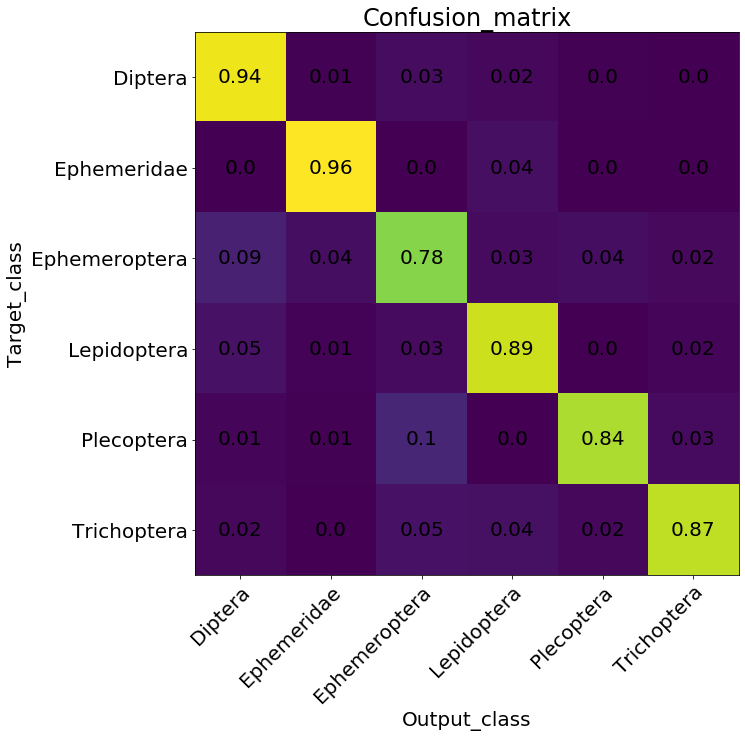

In [13]:
create_confusion_matrix(validation_matrix, ntests, args.labels, args.figure_root, save=args.save_fig)

In [14]:
each_df = compute_each_size_df(result, x_all, y_all)
if args.save_df is True:
    each_df.to_csv(pj(args.figure_root, "each_size_df.csv"))
each_df

,Accuracy,Insect_size
0,True,5632
1,True,13125
2,True,12190
3,True,4148
4,True,323
...,...,...
1319,True,2070
1320,True,3408
1321,False,4224
1322,True,5151


In [15]:
all_df = compute_all_size_df(each_df)
if args.save_df is True:
    all_df.to_csv(pj(args.figure_root, "all_size_df.csv"))
all_df

,order,Accuracy,Insect_size
0,1.0,0.000000,2.000000
1,7.0,1.000000,205.833333
2,8.0,0.882353,395.039216
3,9.0,0.755906,770.850394
4,10.0,0.805085,1504.529661
5,11.0,0.868966,2941.368966
6,12.0,0.925806,5934.145161
7,13.0,0.976077,11264.789474
8,14.0,0.948718,22344.653846
9,15.0,0.800000,34865.400000


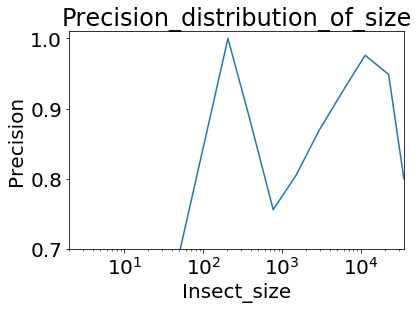

In [16]:
plot_df_distrib_size(all_df, args.figure_root, save=args.save_fig)

### Load and Test model